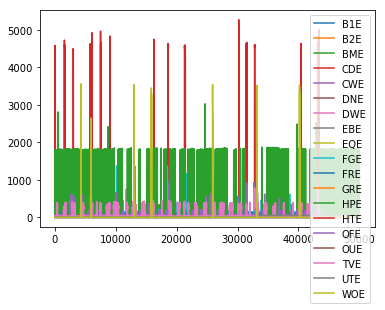

In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA
from itertools import combinations 

# TODO: Get medians values
def get_medians(X, y_pred):    
    P = X[:,0]
    Q = X[:,1]

    medians_P = []
    medians_Q = []
    for idx in range(max(y_pred)+1):
        medians_P.append(np.median([P[i] for i in range(len(y_pred)) if y_pred[i] == idx]))
        medians_Q.append(np.median([Q[i] for i in range(len(y_pred)) if y_pred[i] == idx]))
    
    medians = np.transpose([medians_P, medians_Q])
    return medians


# Get all csv files from the current folder
files = [f for f in os.listdir('.') if os.path.isfile(f) and f[-3:]=='csv' and 'ground_truth' not in f]

# Create list of dataframes from all csv files
data = [pd.read_csv(f) for f in files]

# Get name list to use in dictionary
names = [f[:-4] for f in files]
appliances = [n for n in names if n!='WHE']

# Create dictionary with database.
d = dict(zip(names,data))

# Plot by size 
init = 0
end = 50000

# Sum all active power, except WHE 
all_P = sum(v.P for (k,v) in d.items() if k!='WHE')
all_Q = sum(v.Q for (k,v) in d.items() if k!='WHE')

# Plot all appliances
plt.figure()
for appl in names:
    if appl!='WHE':
        plt.plot(d[appl].P[init:end])

plt.legend([n for n in names if n!='WHE'])
plt.show()

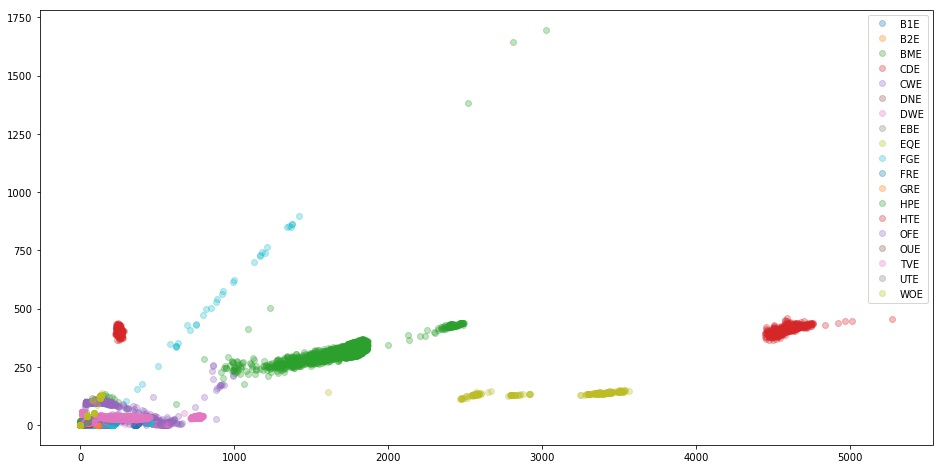

In [14]:
# Plot clusters of active and reactive power
plt.figure(figsize=(16, 8))
for appl in names:
    if appl != 'WHE':
        plt.plot(d[appl].P[init:end], d[appl].Q[init:end],'o', alpha=0.3)

to_leg = [n for n in names if n!='WHE']
plt.legend(to_leg)

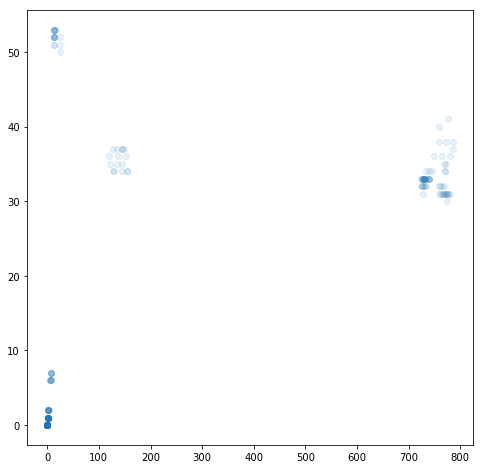

In [15]:
# TODO: Test Baysean Gaussian Mixture clustering
from sklearn.mixture import BayesianGaussianMixture # Import clusterer

# Visualize appliance for test clustering 
init = 0
end = 5000 # minutes

# Set list of colors
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

## Test BGM for one appliance
appl = 'DWE'

# Create vector with P and Q values and plot them
P = d[appl].P[init:end].values
Q = d[appl].Q[init:end].values

# Visualize appliance
plt.figure(figsize=(8, 8))
plt.plot(d[appl].P[init:end], d[appl].Q[init:end],'o', alpha=0.1)

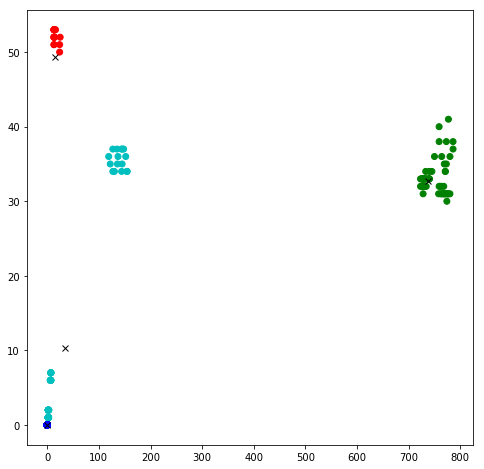

In [16]:
# Create X vector and normalize it
X = np.transpose([P, Q])
sscl = StandardScaler().fit(X)
X = sscl.transform(X)

# Apply clusterer
bgm = BayesianGaussianMixture(n_components=4, covariance_type='full', weight_concentration_prior_type='dirichlet_distribution', random_state=42).fit(X)
y_pred = bgm.predict(X)

# Plot clusters with X unnormalized
X = sscl.inverse_transform(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0],X[:,1], color=colors[y_pred])
means = sscl.inverse_transform(bgm.means_)
plt.plot(means[:,0],means[:,1],'kx')

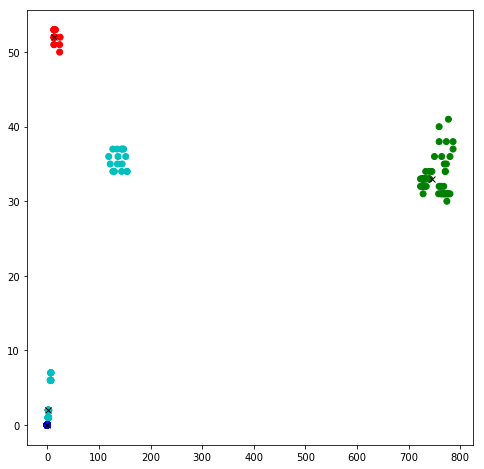

In [17]:
medians = get_medians(X, y_pred)
plt.figure(figsize=(8, 8))
plt.scatter(X[:,0],X[:,1], color=colors[y_pred])
plt.plot(medians[:,0],medians[:,1],'kx')

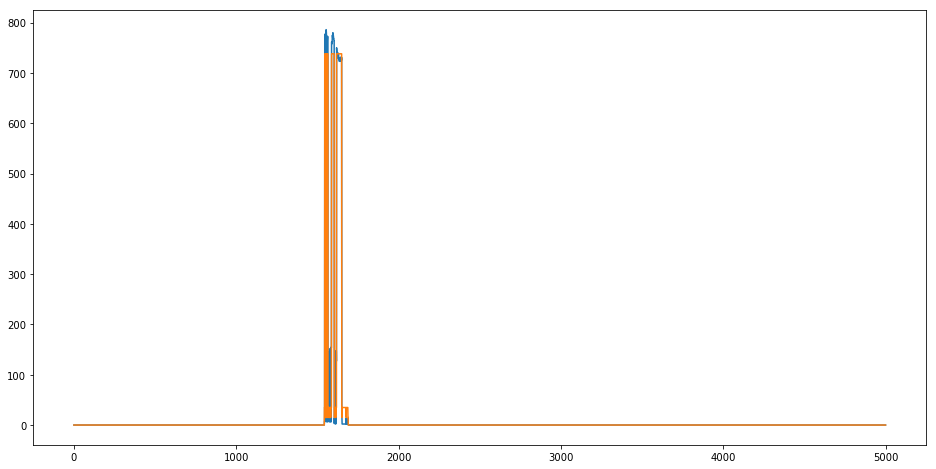

In [18]:
# TODO: Compare mean with ground truth
plt.figure(figsize=(16, 8))
plt.plot(P)
P_pred = means[y_pred][:,0]
plt.plot(P_pred)

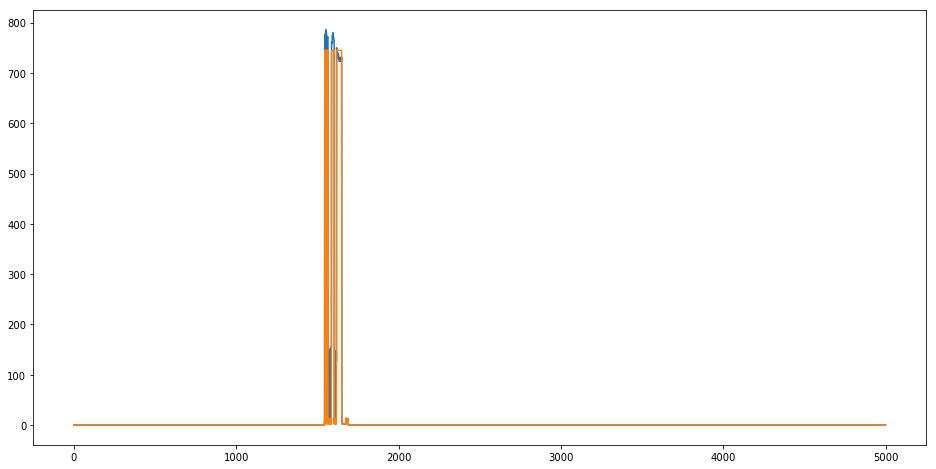

In [19]:
# TODO: Compare median with ground truth
plt.figure(figsize=(16, 8))
plt.plot(P)
P_pred = medians[y_pred][:,0]
plt.plot(P_pred)

No value lower than 30 VA was found in EBE
No value lower than 30 VA was found in OUE
No value lower than 30 VA was found in UTE


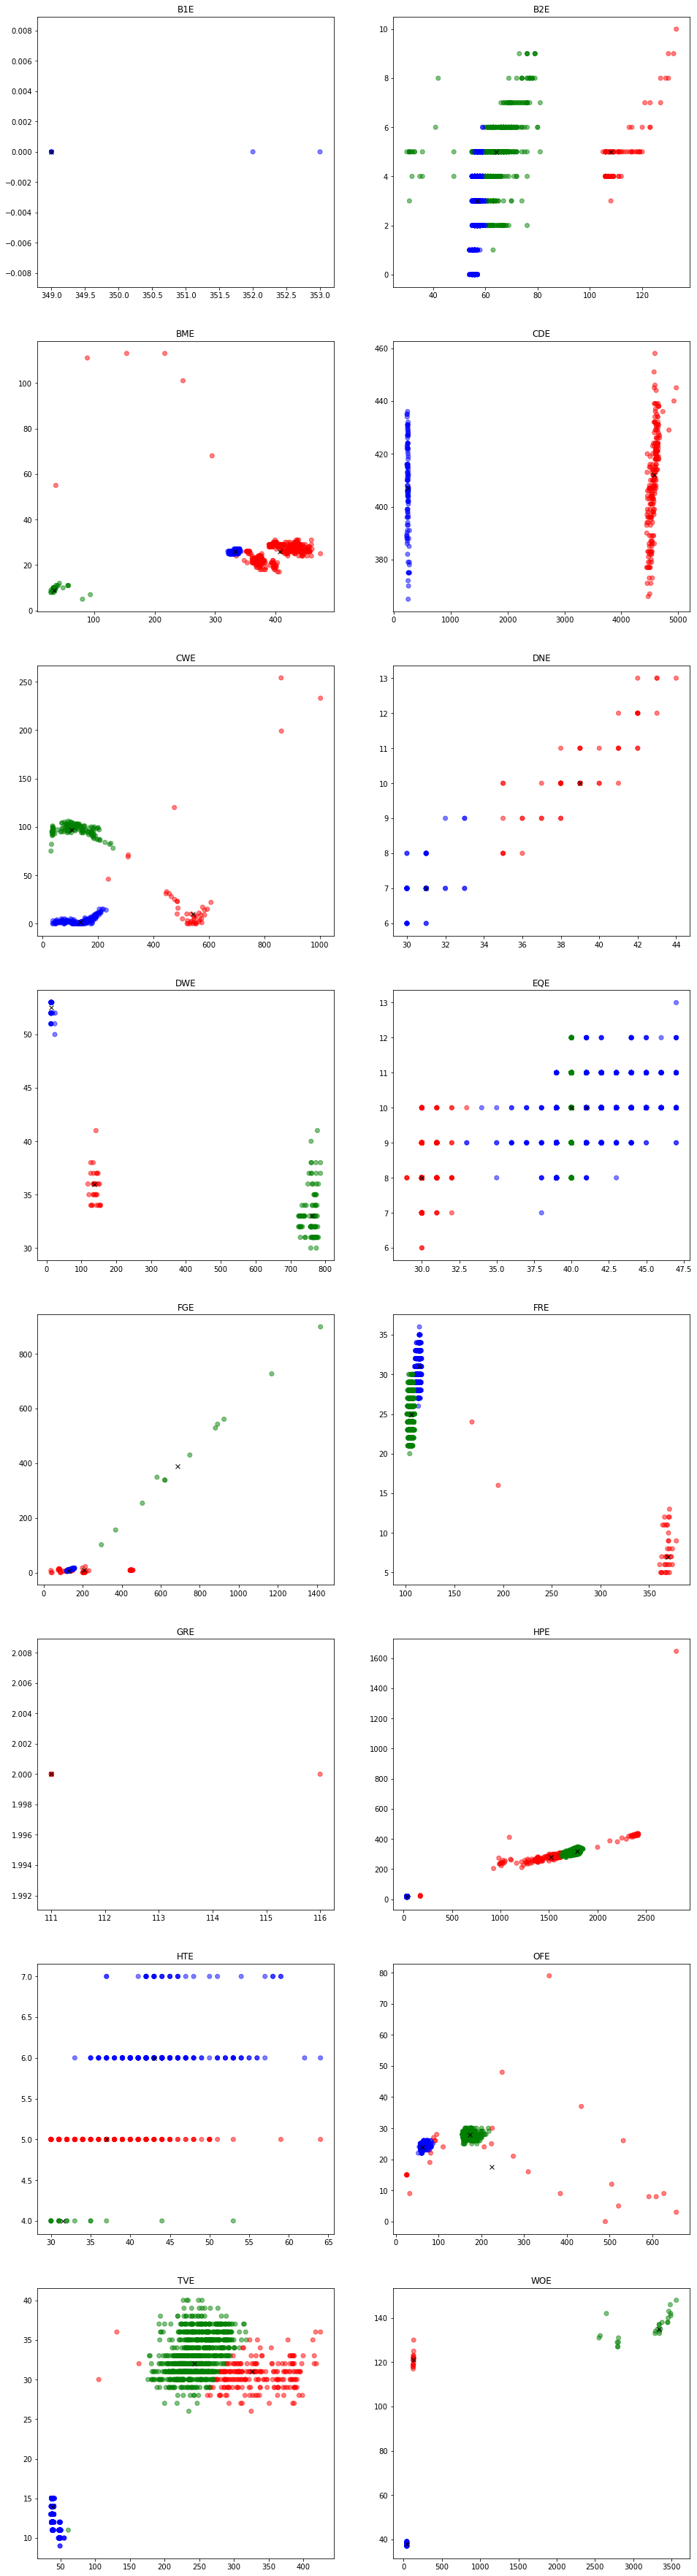

In [24]:
## Test BGM for all appliances
delta = 30 # VA (minimum aparent power to be identified)
init = 0
length = 7*24*60 # 10080 minutes = 1 week
end = init + length

all_medians = {}
plt.figure(figsize=(16, 8*8))
ignore_appl = ['WHE']
i = 1
for appl in appliances:
    plt.subplot(8, 2, i)
    # Create vector with P and Q values
    P = d[appl].P[init:end].values
    Q = d[appl].Q[init:end].values
    X = np.transpose([P, Q])
    X = [x for x in X if LA.norm(x)>=delta] # Ignore values lower than delta VA

    # Normalize X
    if len(X) == 0:
        print 'No value lower than {} VA was found in {}'.format(delta, appl)
        ignore_appl.append(appl)
        continue
    
    sscl = StandardScaler().fit(X)
    X = sscl.transform(X)
    
    # Apply clusterer
    bgm = BayesianGaussianMixture(n_components=3, covariance_type='full', weight_concentration_prior_type='dirichlet_distribution', random_state=42).fit(X)
    y_pred = bgm.predict(X)

    # Plot clusters with X unnormalized
    X = sscl.inverse_transform(X)    
    # plt.figure(figsize=(8, 8))
    plt.scatter(X[:,0],X[:,1], color=colors[y_pred], alpha=0.5)
    means = sscl.inverse_transform(bgm.means_)
    #plt.plot(means[:,0],means[:,1],'kx')
    medians = get_medians(X, y_pred)
    plt.plot(medians[:,0],medians[:,1],'kx')
    plt.title(appl)
    
    all_medians[appl] = medians
    
    i+=1

In [22]:
for (appl, medians) in all_medians.items():

    print 'Median P,Q center values for {} are:'.format(appl)
    print(medians)
    print '='*80


Median P,Q center values for DNE are:
[[ 31.   7.]
 [ nan  nan]
 [ 39.  10.]]
Median P,Q center values for CDE are:
[[  247.   407.]
 [   nan    nan]
 [ 4569.   412.]]
Median P,Q center values for HTE are:
[[ 43.    6. ]
 [ 31.5   4. ]
 [ 37.    5. ]]
Median P,Q center values for B1E are:
[[ 349.    0.]]
Median P,Q center values for FRE are:
[[ 114.   31.]
 [ 106.   25.]
 [ 369.    7.]]
Median P,Q center values for BME are:
[[ 333.   26.]
 [  34.    9.]
 [ 407.   26.]]
Median P,Q center values for EQE are:
[[ 41.  10.]
 [ 40.  10.]
 [ 30.   8.]]
Median P,Q center values for OFE are:
[[  62.    24. ]
 [ 173.    28. ]
 [ 225.    17.5]]
Median P,Q center values for WOE are:
[[   43.    38.]
 [ 3340.   135.]
 [  129.   121.]]
Median P,Q center values for GRE are:
[[  nan   nan]
 [  nan   nan]
 [ 111.    2.]]
Median P,Q center values for DWE are:
[[  14.    52.5]
 [ 762.    33. ]
 [ 138.    36. ]]
Median P,Q center values for TVE are:
[[  38.    14. ]
 [ 243.    32. ]
 [ 326.5   31. ]]
Medi

In [26]:
# TODO: Create ground truth data to feed the model
true_P = sum(v.P for (k,v) in d.items() if k not in ignore_appl)
true_Q = sum(v.Q for (k,v) in d.items() if k not in ignore_appl)


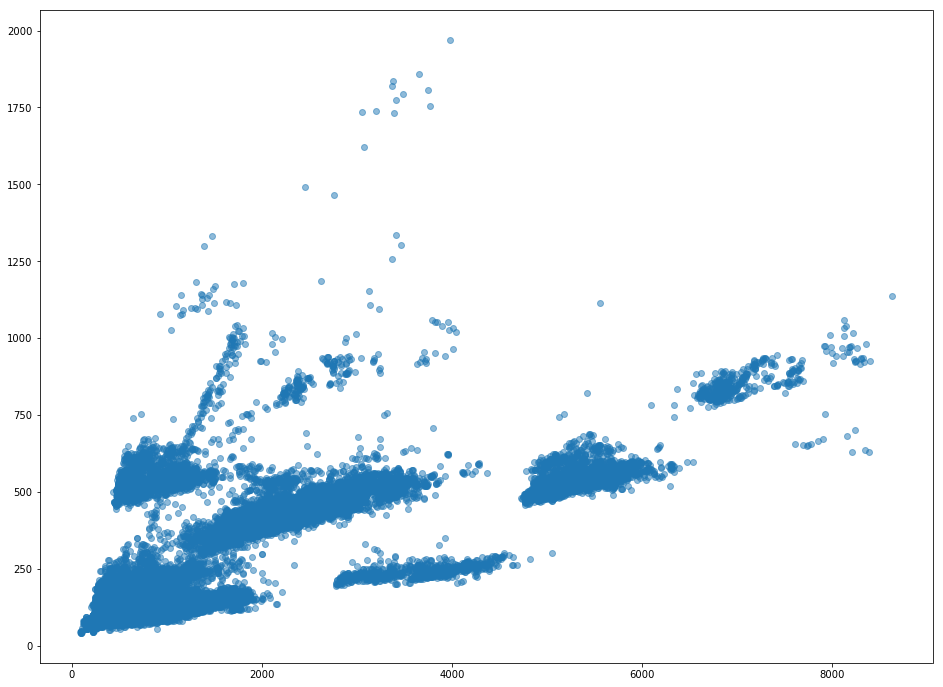

In [32]:
plt.figure(figsize=(16,12))
plt.scatter(true_P, true_Q, alpha=0.5)

In [44]:
# TODO: Export to CSV
df = pd.DataFrame(np.transpose([true_P, true_Q]), index=range(1,len(true_P)+1) , columns = ['P', 'Q'])

In [45]:
df

,P,Q
1,6757,779
2,6777,797
3,6776,785
4,4953,479
5,4972,481
6,4974,478
7,4936,474
8,4922,475
9,4941,472
10,4851,484


In [46]:
df.to_csv('z_ground_truth.csv')